In [3]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
import riip

In [166]:
#Plotting Options
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.style.use('seaborn')

textwidth = 5.9

plt.rc('font', size=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times"

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

wls = np.linspace(1.01,22,61)

## Refractive Index

Import refractive index data to build expected retardance arrays

In [69]:
ri = riip.RiiDataFrame()

In [70]:
ri.search("CdSe")

,book,section,page,formula,tabulated,wl_min,wl_max
id,,,,,,,
662,CdSe,Experimental data,Lisitsa-o,2,f,1.01000,22.00000
663,CdSe,Experimental data,Lisitsa-e,2,f,1.01000,22.00000
664,CdSe,Models and simulations,Ninomiya-o,0,nk,0.23393,1.03320
665,CdSe,Models and simulations,Ninomiya-e,0,nk,0.23393,1.03320
666,CdSe,Models and simulations,Ninomiya-cubic,0,nk,0.20664,0.82656


In [71]:
CdSe_o = ri.material({'id': 662})
CdSe_e = ri.material({'id': 663})

birefringence = interp1d(wls, CdSe_e.n(wls)-CdSe_o.n(wls), kind='cubic')


Extinction coefficient is missing and set to zero.
Extinction coefficient is missing and set to zero.


In [72]:
def retardance(wavelength,thick):
    d = float(birefringence(wavelength))
    return(thick*d*1000)

## CD Model

In [73]:
#The Demodulation Kernals 
def I1(lambda_c,thick,aolp = 0):
    delta = 2*math.pi * retardance(lambda_c,thick) /lambda_c
    return(1+np.cos(delta+2*aolp))

def I2(lambda_c,thick,aolp = 0):
    delta = 2*math.pi * retardance(lambda_c,thick) /lambda_c
    return(1-np.cos(delta+2*aolp))

In [74]:
res = 1000
xpos = np.linspace(0,61,61*res);

In [75]:
def pos(lambda_c):
    return(61*res/5 *(lambda_c-7))

In [601]:
#width is in pixels
def PSF(D, wavelength, f):
    #x in mm
    xi = xpos/((wavelength)*f)
    p= np.sinc(D*xi)**2
    return(p)

In [602]:
width = 1

def average(arr, n):
    end =  n * int(len(arr)/n)
    return np.mean(arr[:end].reshape(-1, n), 1)

def mod(width,thick,aolp = 0):
    S1 = np.zeros(61*res)
    S2 = np.zeros(61*res)
    for l in np.linspace(7,12,100):
        i1 = I1(l,thick,aolp)
        i2 = I2(l,thick,aolp)
        S1 = S1 + i1*PSF(width,l,6.3)
        S2 = S2 + i2*PSF(width)
    N = 1000;
    S1 = average(S1, N)
    S2 = average(S2, N)
    return((S1-S2)/(S1+S2),np.max(S1))

def mod_continuous(thick,aolp = 0):
    S1 = np.zeros(200)
    S2 = np.zeros(200)
    j = 0
    for l in np.linspace(7,12,200):
        i1 = I1(l,thick,aolp)
        i2 = I2(l,thick,aolp)
        S1[j] = i1
        S2[j] = i2
        j = j+1
    return((S1-S2)/(S1+S2))

def path_continuous(thick,aolp = 0):
    S1 = np.zeros(61)
    S2 = np.zeros(61)
    j = 0
    for l in np.linspace(7,12,61):
        i1 = I1(l,thick,aolp)
        i2 = I2(l,thick,aolp)
        S1[j] = i1
        S2[j] = i2
        j = j+1
    return([S1,S2])

In [604]:
N = 100;
wls = np.linspace(7,12,61)
plt.plot(wls,mod(1,5.01),'.-',label = '1')
plt.plot(wls,mod(3,5.01),'.-',label = '3')
plt.plot(wls,mod(5,5.01),'.-',label = '5')

plt.ylabel("Modulation Function")
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
plt.legend("PSF Width")
plt.gcf().set_dpi(300)

ValueError: operands could not be broadcast together with shapes (610000,) (61000,) 

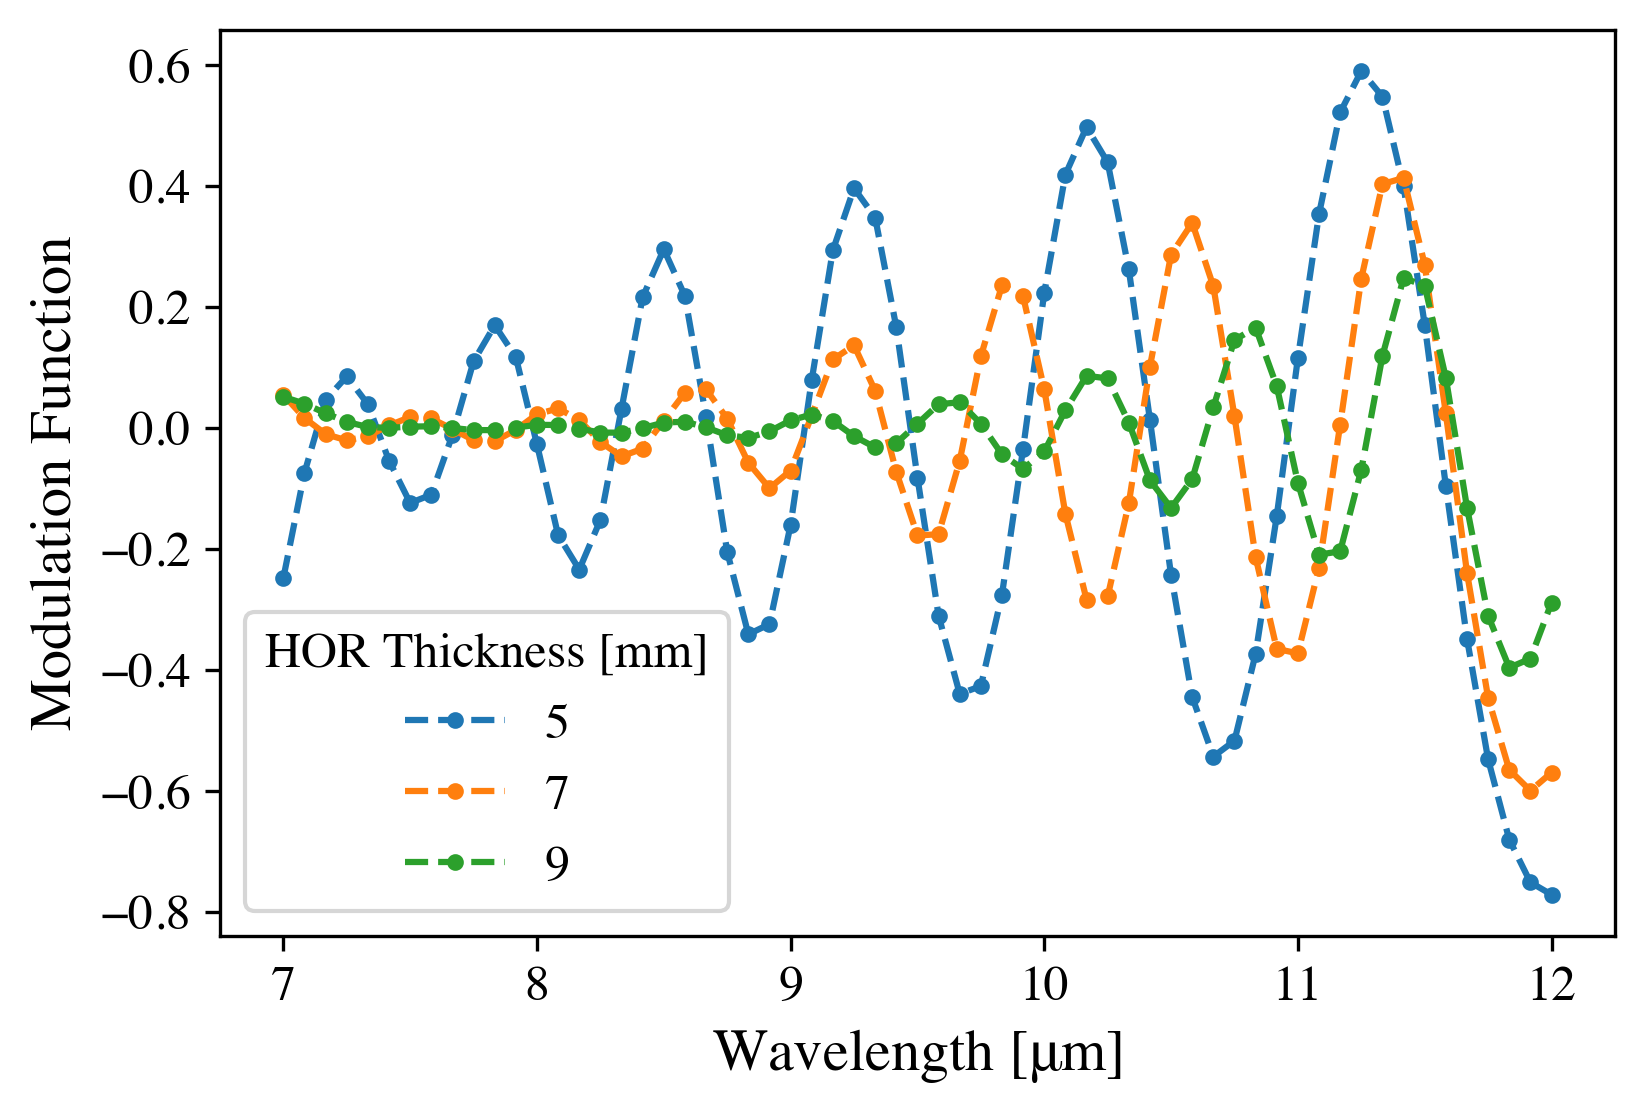

In [314]:
N = 61;

plt.plot(wls,mod(6,5.01)[0],'.--',label = '5')
#plt.plot(np.linspace(7,12,200),mod_continuous(5.01),'r',label = 'Discrete')
plt.plot(wls,mod(6,7.01),'.--',label = '7')
#plt.plot(np.linspace(7,12,200),mod_continuous(7.01),'b',label = 'Discrete')
plt.plot(wls,mod(6,9.01),'.--',label = '9')

plt.ylabel("Modulation Function")
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
#plt.title("t = 7.01 mm")
plt.legend(title = "HOR Thickness [mm]")
plt.gcf().set_dpi(300)

In [408]:
angles = np.linspace(0,np.pi,180)
eff = np.zeros([61,61])
thicks = np.linspace(.1,10,61);
for t in range(61):
    cal = np.zeros([180,61])
    mag = np.zeros([180,61])
    for i in range(180):
        cal[i],mag[i] = mod(thicks[t],5.01,aolp = angles[i])
       
    eff[t] = np.max(cal)

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


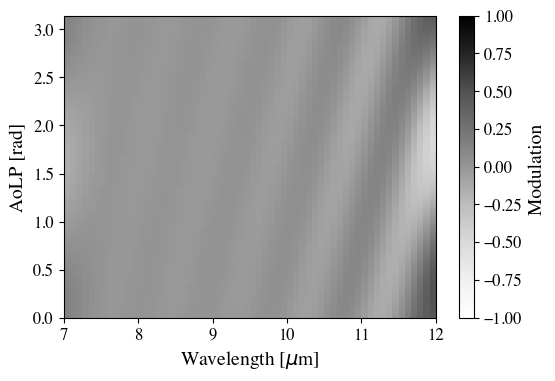

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


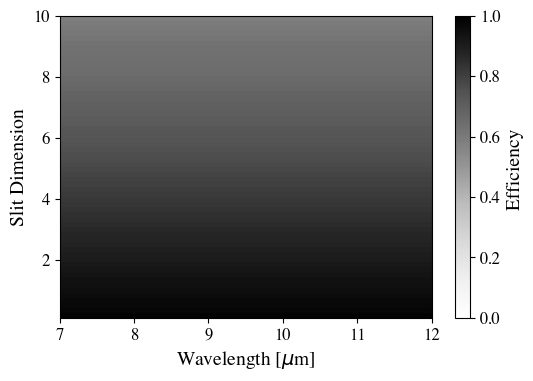

In [414]:
plt.pcolormesh(wls, angles,cal,vmin = -1,vmax = 1, cmap = "Greys")
plt.ylabel("AoLP [rad]")
plt.xlabel("Wavelength [$\mu$m]")
plt.colorbar(label = "Modulation ")
plt.gcf().set_dpi(100)
plt.show()

In [426]:
samp = 10
angles = np.linspace(0,np.pi,90)
eff = np.zeros([samp,samp])
thicks = np.linspace(3,8,samp)
slits = np.linspace(0.5,10,samp)
for s in range(samp):
    for t in range(samp):
        cal = np.zeros([90,61])
        mag = np.zeros([90,61])
        for i in range(90):
            cal[i],mag[i] = mod(slits[s],thicks[t],aolp = angles[i])
       
    eff[t,s] = np.max(cal)

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


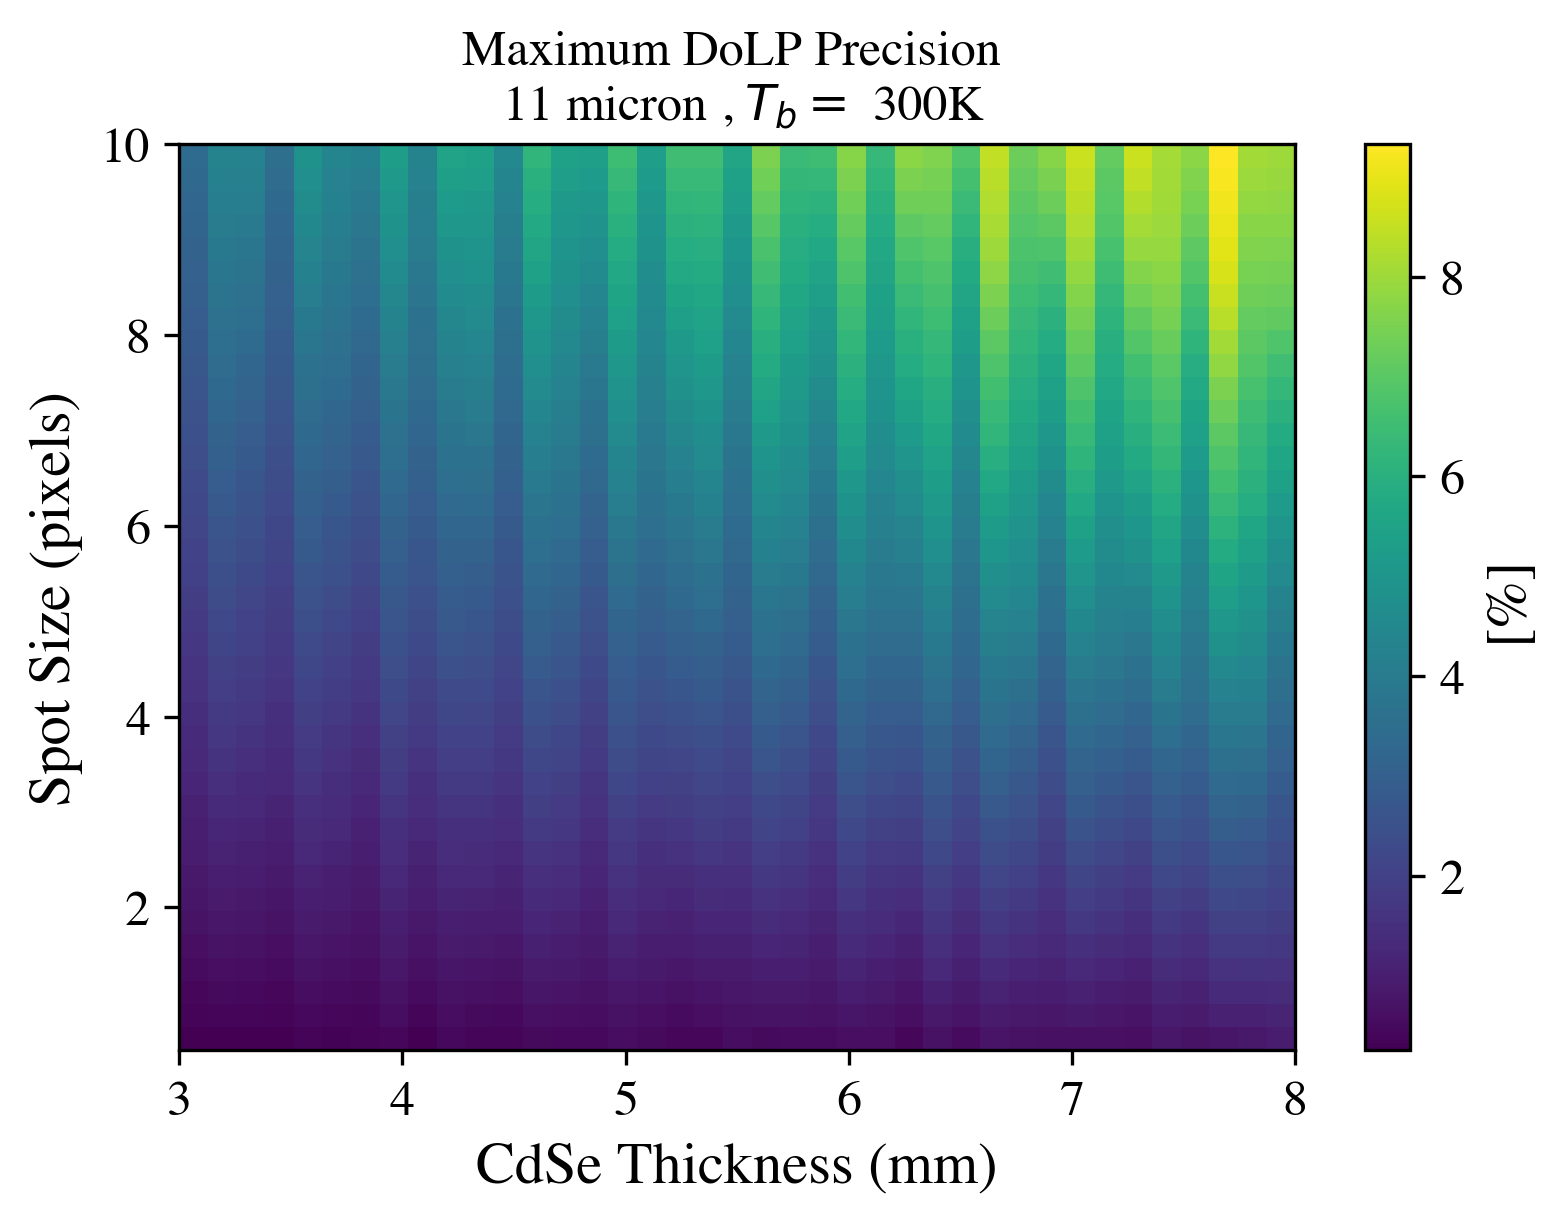

In [420]:

plt.pcolormesh(thicks,slits,eff)
plt.ylabel("Spot Size (pixels)")
plt.xlabel("CdSe Thickness (mm)")
plt.title("Maximum DoLP Precision \n 11 micron , $T_b = $ 300K")
plt.colorbar(label = "[%]")
plt.gcf().set_dpi(300)
plt.show()

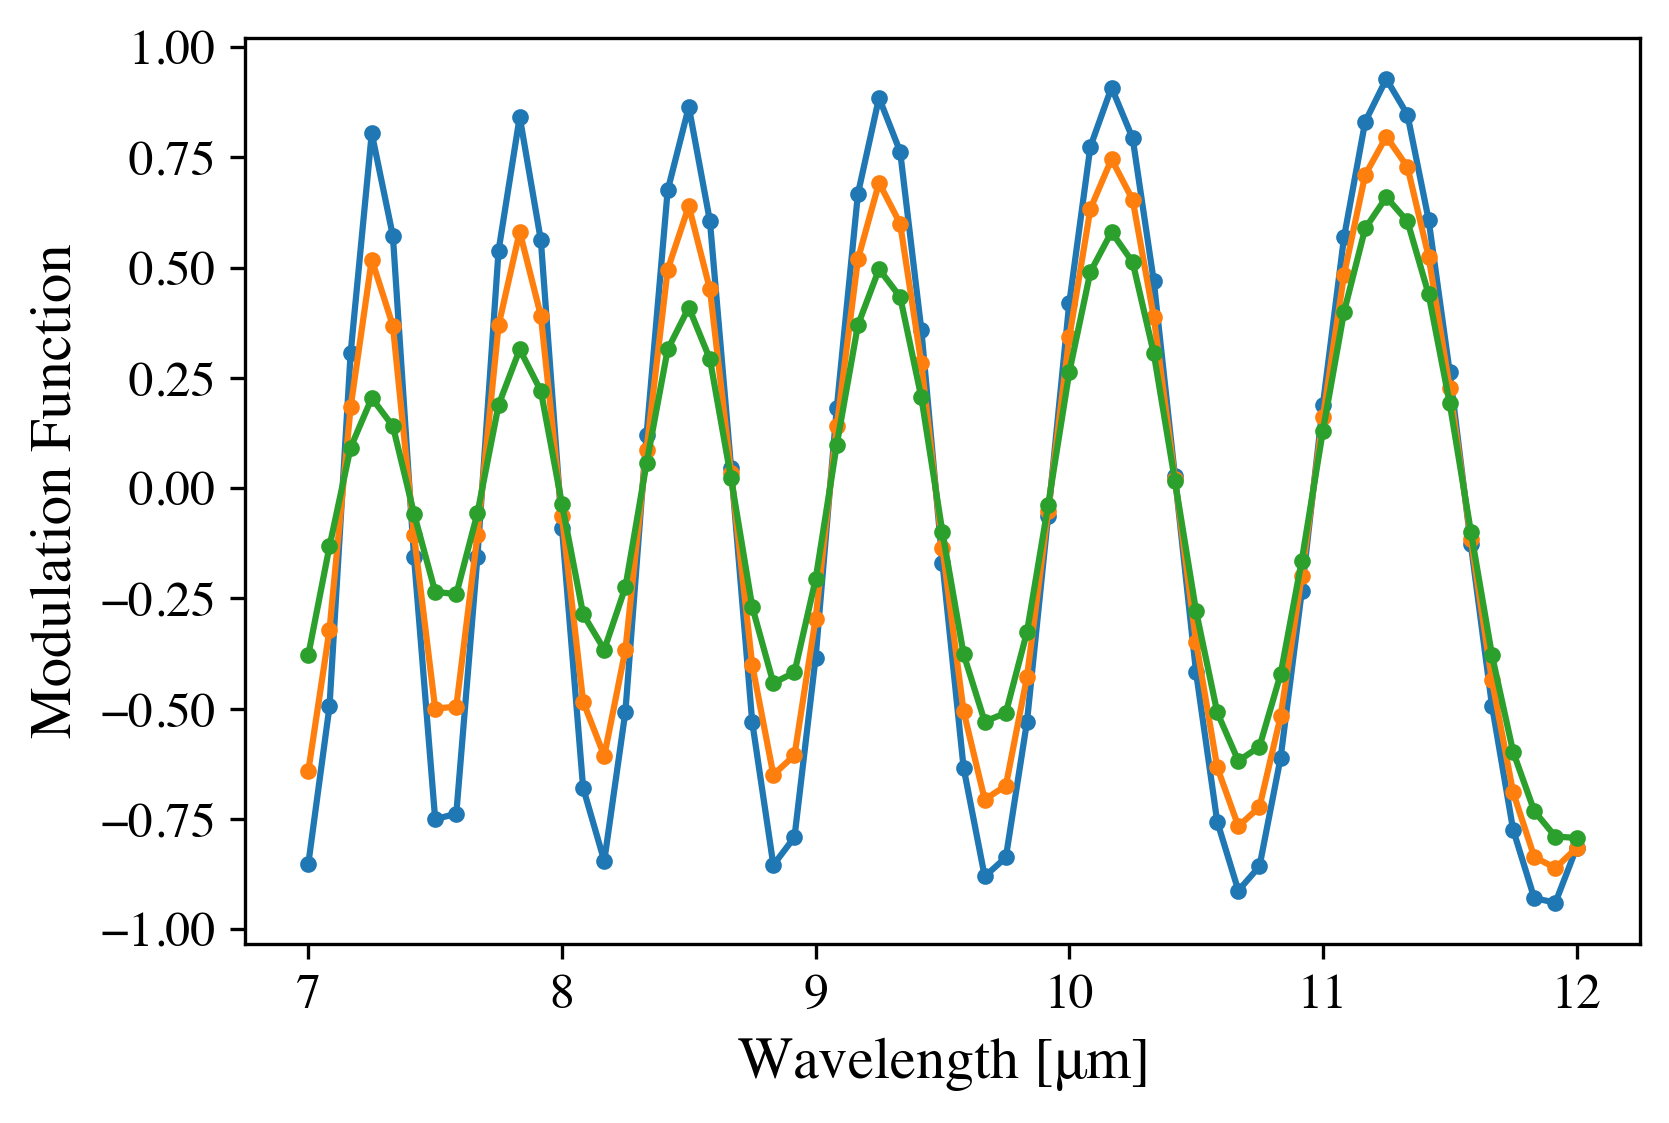

In [315]:
N = 1000;
wls = np.linspace(7,12,61)
plt.plot(wls,mod(1,5.01),'.-',label = '1')
plt.plot(wls,mod(3,5.01),'.-',label = '3')
plt.plot(wls,mod(5,5.01),'.-',label = '5')

plt.ylabel("Modulation Function")
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
#plt.legend()
plt.gcf().set_dpi(300)

## MTF

In [543]:
def psf(x, D, wavelength, f):
    #x in mm
    xi = x/((wavelength)*f)
    p= np.sinc(D*xi)**2
    return(p)

def MTF(xi, D, wavelength, f):
    #x in mm
    xio = D/(wavelength)*f
    p= 2/np.pi *(np.arccos(xi/xio)-(xi/xio)*np.sqrt(1-(xi/xio)**2))
    return(p)

def slit(x,Dslit,loc):
    if np.abs(x-loc) > Dslit:
        p =0
    else:
        p=1  
    return(p)

def grating(f,d,wave):
    beta = np.arcsin(wave/d)
    return(20*(beta)/f -.8)

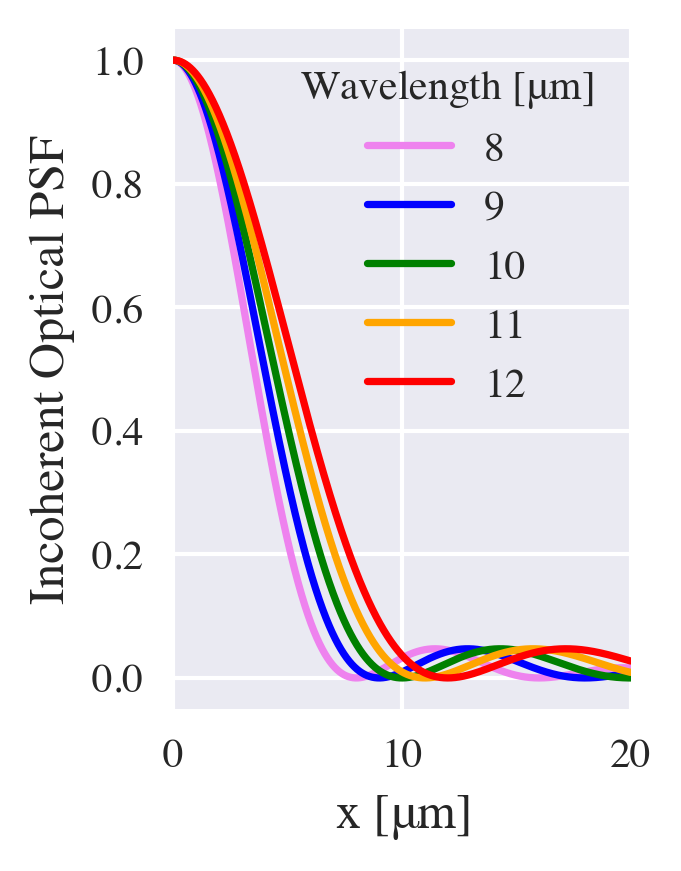

In [585]:
fig = plt.subplots(1,figsize = (textwidth/3 ,3))
waves = [8,9,10,11,12]
xs = np.linspace(0,.04,res)
colors = ['violet','blue','green','orange','red']
for i in range(5):
    p = list(map(lambda x: psf(x,6.3,waves[i]*1e-3,6.3), xs))
    plt.plot(xs*1000,p,c = colors[i],label = str(waves[i]))
plt.ylabel("Incoherent Optical PSF")
plt.xlabel("x [$\mathdefault{\mu m}$]")
plt.xlim(0,20)
plt.gcf().set_dpi(300)
plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]')

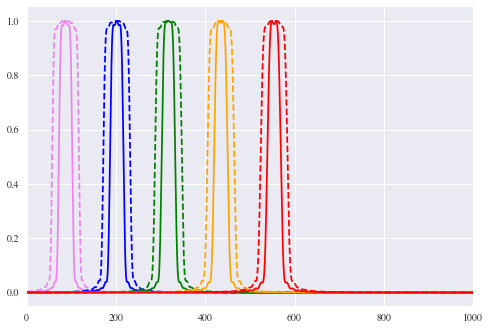

In [587]:
xs = np.linspace(-1,1,res)
for i in range(5):
    wl =waves[i]*1e-3;
    p = list(map(lambda x:  psf(x,6.3,wl,6.3), xs))
    d = list(map(lambda x: slit(x,15e-3,grating(6.3,.029,wl)), xs))
    cov =np.convolve(d,p)
    plt.plot(xs*1e3,cov[int(res/2):int(3*res/2)]/max(cov),c = colors[i])
    
    
    d = list(map(lambda x: slit(x,30e-3,grating(6.3,.029,wl)), xs))
    cov =np.convolve(d,p)
    plt.plot(xs*1e3,cov[int(res/2):int(3*res/2)]/max(cov),'--',c = colors[i])
    
plt.xlim([0,1000])
plt.show()

In [598]:
array1 = np.zeros(res)
array2 = np.zeros(res)
for w in np.linspace(6.5,13,100):
    wl =w*1e-3;
    p = list(map(lambda x:  psf(x,6.3,wl,6.3), xs))
    d = list(map(lambda x: slit(x,15e-3,grating(6.3,.028,wl)), xs))

    cov =np.convolve(d,p)
    f = cov[int(res/2):int(3*res/2)]/max(cov)
        
    i1 = I1(w,5.01,aolp = 0)
    i2 = I2(w,5.01,aolp = 0)
    array1 = array1 + f*i1
    array2 = array2 + f*i2

In [599]:
array1b = np.zeros(res)
array2b = np.zeros(res)
for w in np.linspace(6.5,13,100):
    wl =w*1e-3;
    p = list(map(lambda x:  psf(x,6.3,wl,6.3), xs))
    d = list(map(lambda x: slit(x,50e-3,grating(6.3,.028,wl)), xs))

    cov =np.convolve(d,p)
    f = cov[int(res/2):int(3*res/2)]/max(cov)
        
    i1 = I1(w,5.01,aolp = 0)
    i2 = I2(w,5.01,aolp = 0)
    array1b = array1b + f*i1
    array2b = array2b + f*i2

Text(0, 0.5, 'Continuous $\\mathdefault{M(\\lambda)}$')

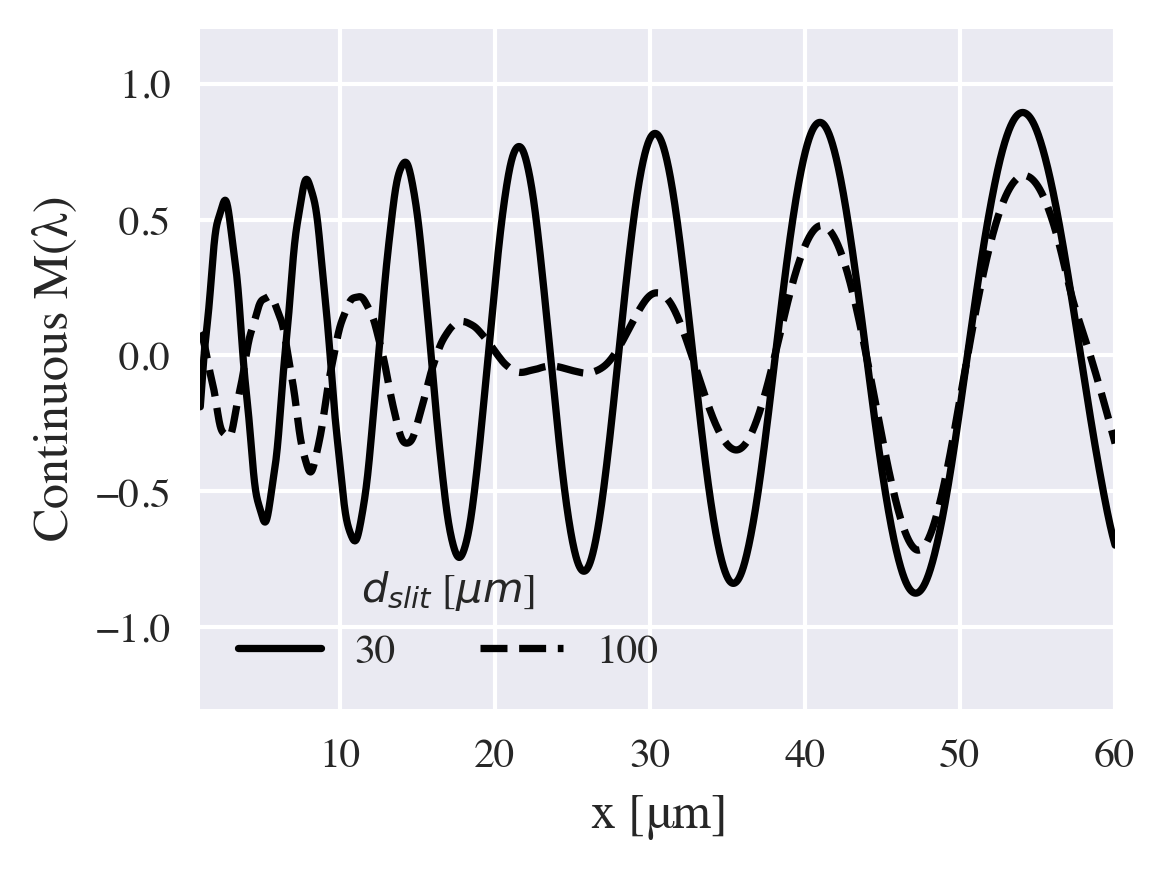

In [600]:
fig = plt.subplots(1,figsize = (2*textwidth/3 ,3))
plt.plot(xs*1e3/12,(array1-array2)/(array1+array2),'k',label = '30')
plt.plot(xs*1e3/12,(array1b-array2b)/(array1b+array2),'k--',label = '100')
plt.xlim(1,60)
plt.ylim(-1.3,1.2)
plt.gcf().set_dpi(300)
plt.legend(title = '$d_{slit}$ [$\mu m$]', ncol=2)
plt.xlabel("x [$\mathdefault{\mu m}$]")
plt.ylabel('Continuous $\mathdefault{M(\lambda)}$')